Проанализировать данные по выживаемости. Обучить модель предсказания выживет ли человек или нет (ключевая переменная) (различные варианты визуализации можно посмотреть здесь https://www.kaggle.com/competitions/titanic/code?competitionId=3136&sortBy=scoreDescending&language=Python).
Определить наиболее значимые переменные которые влияют на выживаемость. 
Визуализировать дерево решений. 
Написать вывод. 
Не копировать бездумно чужие работы. 


Ответить на вопросы (обоснованно).

1. Как влияет размер семьи  на вероятность виживаемости (одинокие выживают чаще или нет?, люди у которых большая семья (больше 4) выживают чаще или нет).
2. Как влияет пол/возраст/номер палубы. 


Анализ и план работы.
Загружаем тренировочный и тестовый датасеты с данными по Титанику.
Выбираем только колонки с нужной нам информацией.
С помощью CatBoost строим модель дерева решений.
Проверяем влияние перечисленных в задании факторов на выживаемость пассажиров при катастрофе.


In [34]:
%reset
# Importing libraries
import pandas as pd

# Loading datasets
train_table = pd.read_csv('titanic_train.csv')
test_table = pd.read_csv('titanic_test.csv')

# Viewing first strings:
print(train_table.head())

Nothing done.
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN

In [35]:
# check colums types
train_table.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [36]:
# check colums types
test_table.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Здесь:

PassengerId - идентификатор пассажира.

Survived - целевая переменная - выжил ли пассажир.

Pclass - класс проезда

Name - имя пассажира

Sex - пол

Age - возраст

SibSp - кол-во братьев и/или сестер + супруг/супруга

Parch - кол-во детей и/или родителей на борту

Ticket - каки-то сложно интерпретируемые данные билета (точнее, номер-то понятен, а дополнительные цифирки и буковки навряд ли)

Fare - плата за проезд

Cabin - каюта

Embarked - порт отправления

Видим, что в тестовом наборе данных нету ключевой для нас переменной Survived. И зачем нам, тогда, спрашивается, тестовый набор? 
Инференсом мы тут заниматься не собираемся уж точно.
Далее работаем только с тренировчным набором данных.
Также отметим, что из этих данных нам не понадобятся идентификатор и имя пассажира. Также данные по билету (в большинстве случаев это просто номер билета) навряд ли что-то нам дадут.
Данные по каюте потенциально могли бы сообщить что-то полезное, если бы они были сгруппированы по палубам. А в таком виде от номера каюты толку не будет, удаляем.

Размеры датафрейма:

In [37]:
print(train_table.shape)

(891, 12)


In [38]:
train_table = train_table.drop(['PassengerId','Name', 'Ticket', 'Cabin'], axis=1) # axis = 1 for columns
print(train_table.shape)


(891, 8)


In [39]:
print('How many omitted data in each column:')
print(train_table.isna().sum())

How many omitted data in each column:
Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64


Видим, что в колонках возраста и места посадки есть пропуски.
По идее, для  обработки с помощью дерева решений это не является показанием к устранению NaN. За что мы этот метод и любим.
Однако конкретно с CatBoost этот финт не прошел. Пришлось заменять на средний возраст.

In [40]:
train_table['Age'] = train_table['Age'].fillna(train_table['Age'].median())
train_table = train_table.dropna(subset=['Embarked'])

In [41]:
print(train_table.isna().sum())

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


В соответствии с заданием рассчитываем размер семьи

In [42]:
# Assigning family size
train_table['FamilySize'] = train_table['SibSp'] + train_table['Parch']  + 1 # 1 for a family with only one person

In [43]:
print(train_table.head())

   Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked  FamilySize
0         0       3    male  22.0      1      0   7.2500        S           2
1         1       1  female  38.0      1      0  71.2833        C           2
2         1       3  female  26.0      0      0   7.9250        S           1
3         1       1  female  35.0      1      0  53.1000        S           2
4         0       3    male  35.0      0      0   8.0500        S           1


Заменим пол на цифру

In [44]:
train_table['Sex'] = train_table['Sex'].map({'female': 1, 'male': 0})

Заменим букву порта погрузки на булевские значения

In [45]:
# port of embarkation - to 0/1
train_table = pd.get_dummies(train_table, columns=['Embarked'])

In [46]:
print(train_table.head())

   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  FamilySize  Embarked_C  \
0         0       3    0  22.0      1      0   7.2500           2           0   
1         1       1    1  38.0      1      0  71.2833           2           1   
2         1       3    1  26.0      0      0   7.9250           1           0   
3         1       1    1  35.0      1      0  53.1000           2           0   
4         0       3    0  35.0      0      0   8.0500           1           0   

   Embarked_Q  Embarked_S  
0           0           1  
1           0           0  
2           0           1  
3           0           1  
4           0           1  


Разделяем выборку на таблицу признаков и на колонку целевых переменных

In [47]:
# Splitting into features table and label column
X = train_table.drop(['Survived'], axis=1) # axis = 1 for columns
y = train_table['Survived'] 

Дерево решений с помощью CatBoost

In [48]:
import catboost
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Categorical features conversion
# cat_features = ['Sex', 'Embarked']  # Categorical features 
# X[cat_features] = X[cat_features].astype('category')

# Splitting X, y into training and test dataset (with known labels!)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating and training the model
# model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=3, verbose=0) # controlled depth
model = CatBoostClassifier(iterations=100, learning_rate=0.1, verbose=0)

model.fit(X_train, y_train)

# Model evaluation
y_pred = model.predict(X_test) # prediction based on the tast sample
# Calculating all the metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')
print(f'ROC-AUC: {roc_auc:.2f}')
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.80
Precision: 0.77
Recall: 0.70
F1-score: 0.73
ROC-AUC: 0.78
Accuracy: 0.80


Метрики достаточно близки друг ко другу.
Визуализируем полученное дерево.

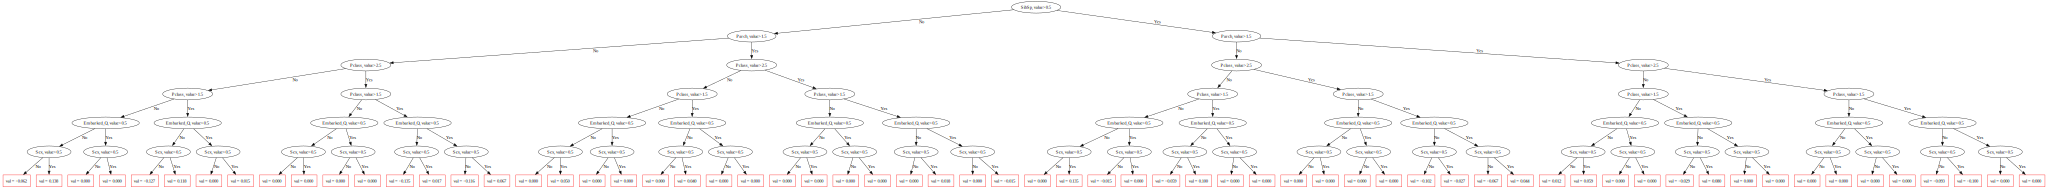

In [51]:
import matplotlib.pyplot as plt

# %matplotlib inline
import os
# os.environ["PATH"] += os.pathsep + 'd:/Download/Graphviz/Graphviz-12.2.1-win64/bin/'
os.environ["PATH"] += os.pathsep + 'e:/Install/!Coding/Graphviz-12.2.1/Graphviz-12.2.1-win64/bin/'

# plt.figure(figsize=(10, 10))
model.plot_tree(tree_idx=0, pool=Pool(X_train, y_train))
# plt.title("Visualization of Decision Tree")
# plt.show()

Выводы.
Проделана обработка датасета "Титаник".
Построено дерево решений на основе библиотеки CatBoost.
Построена визуализация дерева решений для глубины дерева 1, 2 и 3. А затем построено дерево еще без ограничения глубины.
Полученные рисунки сохранены отдельно в файлах CatBoost*.png. Большое дерево без ограничения глубины даже экспортировать не удалось (не работают ни кнопки экспорта в pdf, ни сохранение картинки как графического файла).

Можно сделать несколько выводов на основании полученных результатов.
На вероятность выживания пассажира влияет пол в первую очередь. Для женщин вероятность выше.
Далее в нашем рассмотрении повлиял, как это ни странно, порт погрузки (обозначенный как Q).
Кроме того, влияет класс билета.
Далее, влияет количество родственников.

Хотя в целом работа с CatBoost оставила больше вопросов, чем ответов.
Визуализация заработала только после распаковки Виндовс-пакета Graphviz. Как поместить изображаемое дерево в пределы plt.figure, непонятно (у меня не вышло)
Получаемые в концевых узлах (т.е. листьях) дерева решений значения val не поддаются прямой интерпретации (это не вероятности и не количество элементов выборки, приходящихся на данный узел).
Интерпретация полученного дерева тоже, против ожиданий, затруднительна.
В итоге мы проделали тот же расчет с помощью RandomForestClassifier (в другом файле).
